## Imports

In [1]:
import pandas as pd
from gurobipy import *
from matplotlib import pyplot as plt
from matplotlib.patches import FancyArrowPatch 

## Helper functions

In [2]:
'''
    Reading the data from Excel file:
        - X and Y coordinates of points
        - X and Y coordinates and dimensions of blocks 
        
    :return: (tuple) points, blocks - list of the points and block from data
'''
def readData():
    xls = pd.ExcelFile("data.xlsx")
    
    # Getting point coordinates
    sheet = xls.parse(0) 
    
    xCoordinates = list(sheet['X-coordinate'])
    yCoordinates = list(sheet['Y-coordinate'])
    points = [(xCoordinates[i], yCoordinates[i]) for i in range(len(xCoordinates))]
    
    # Getting block data
    sheet = xls.parse(1, skiprows = [0])
    
    xCoordinates = list(sheet['X coordinate'])
    yCoordinates = list(sheet['Y coordinate'])
    widths = list(sheet['Width'])
    heights = list(sheet['Height'])
    blocks = [(xCoordinates[i], yCoordinates[i], widths[i], heights[i]) for i in range(len(xCoordinates))]
    
    return points, blocks

In [3]:
'''
    Finding Manhattan distance between two given points
    
    :param: (tuple) point1 - first given point
    :param: (tuple) point2 - second given point
    :return: (number) Manhattan distance between the point1 and point2
'''
def manhattanDistance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    
    return abs(x1 - x2) + abs(y1 - y2)

In [4]:
'''
    Calculating the distance pairs between the given list of points
    
    :param: (list) points - the given list of points
    :return: (list) Cij - 2D matrix for pair-wise distances
    
    e.g. C[1][2] - Manhattan distance between Point 1 and Point 2
'''
def calculateDistances(points):
    Cij = [[1] * len(points) for i in range(len(points))]
    
    for i in range(0, len(points)):
        for j in range(0, len(points)):
            Cij[i][j] = manhattanDistance(points[i], points[j])

    return Cij

In [5]:
'''
    Calculating the block parameter for every pair of points
    
    :param: (list) points - the given list of points
    :param: (list) blocks - the given list of blocks
    :return: (list) Bij - 2D matrix for pair-wise passing status for points
    
    e.g. B[1][2] - 1 if there is a non-blocking path from Point 1 to Point 2 
'''
def calculateBlocks(points, blocks):
    Bij = [[1] * len(points) for i in range(len(points))]
    Dij = [[None] * len(points) for i in range(len(points))]
    
    for i in range(len(points)):
        for j in range(len(points)):
            firstPathCounts = []
            secondPathCounts = []
        
            for block in blocks:
                firstPath, secondPath = checkBlockBetweenTwoPoints(points[i], points[j], block)
                firstPathCounts.append(firstPath)
                secondPathCounts.append(secondPath)
            
            firstPathResult = False not in firstPathCounts
            secondPathResult = False not in secondPathCounts
            
            Bij[i][j] = int(firstPathResult or secondPathResult)

            # 1 for first x then y; 2 for first y then x
            if firstPathResult is True:
                Dij[i][j] = 1
            elif secondPathResult is True:
                Dij[i][j] = 2
            
    return Bij, Dij

In [6]:
'''
    Checking whether the given block is on the way from a given point to another one
    
    :param: (tuple) point1 - the first given point
    :param: (tuple) point2 - the second given point
    :param: (tuple) block - the given block
    :return: (tuple) first_path, second_path - passing status for the 1st main path and the 2nd main path
    
        (p1_x, p1_y)
           (*)--------
            |        |  <-(1)-
            |        |
            |        |
    -(2)->  |  ||    |
            ---||---(*)(p2_x, p2_y)
            
    (1) - first main path  (first in x direction then in y direction)  -> not blocked
    (2) - second main path (first in y direction then in x direction)  -> blocked
'''
def checkBlockBetweenTwoPoints(point1, point2, block):
    p1_x, p1_y = point1
    p2_x, p2_y = point2
    b_x, b_y, b_w, b_h = block
    
    # X direction
    dir_x = 1 if p1_x < p2_x else -1
    
    # Y direction
    dir_y = 1 if p1_y < p2_y else -1
    
    first_path = False
    second_path = False
    
    # 1st - main path
    checkpoint_1 = True
    for i in range(p1_x, p2_x, dir_x):
        if blockContainsPoint(block, (i, p1_y)) is True:
            checkpoint_1 = False
            break
    
    if checkpoint_1 is True:
        checkpoint_2 = True
        for i in range(p1_y, p2_y, dir_y):
            if blockContainsPoint(block, (p2_x, i)) is True:
                checkpoint_2 = False
                break
        if checkpoint_2 is True:
            first_path = True

    # 2nd - main path
    checkpoint_3 = True
    for i in range(p1_y, p2_y, dir_y):
        if blockContainsPoint(block, (p1_x, i)) is True:
            checkpoint_3 = False
            break
    
    if checkpoint_3 is True:
        checkpoint_4 = True
        for i in range(p1_x, p2_x, dir_x):
            if blockContainsPoint(block, (i, p2_y)) is True:
                checkpoint_4 = False
                break
        if checkpoint_4 is True:
            second_path = True
        
    return first_path, second_path

In [7]:
'''
    Checking whether the given point is inside the given block
    
    :param: (tuple) block - the given block
    :param: (tuple) point - the given point
    :return: (bool) True if the point is in the block, otherwise False
'''
def blockContainsPoint(block, point):
    p_x, p_y = point
    b_x, b_y, b_w, b_h = block
    
    return (b_x <= p_x <= b_x + b_w) and (b_y <= p_y <= b_y + b_h)

## Parameters & Constants

In [8]:
# Constants
points, blocks = readData()
N = len(points)

# Parameters
C = calculateDistances(points)
B, D = calculateBlocks(points, blocks)

## Creating Model

In [9]:
model = Model()

Using license file /Users/fuadaghazada/gurobi.lic
Academic license - for non-commercial use only


## Decision Variables

In [10]:
x = {}
for i in range(N):
    for j in range(N):
        x[i, j] = model.addVar(vtype = GRB.BINARY, name = f"X_{i}_{j}")
    model.update()
    
u = {}
for i in range(N):
    u[i] = model.addVar(vtype = GRB.CONTINUOUS, name = f"U_{i}")

## Constraints

In [11]:
'''
    [i]sum(x[i][j]) for all j = 1
'''
for i in range(N):    
    model.addConstr(sum(x[i, j] for j in range(N)), GRB.EQUAL, 1)
    
model.update()

In [12]:
'''
    [j]sum(x[i][j]) for all i = 1
'''
for j in range(N):
    model.addConstr(sum(x[i, j] for i in range(N)), GRB.EQUAL, 1)
    
model.update()

In [13]:
'''
    [i]sum(x[i][j]) for all i = 0
'''
for i in range(N):
    model.addConstr(x[i, i], GRB.EQUAL, 0)
    
model.update()

In [14]:
'''
    Subtour elimination constraint:
    
    u[i] - u[j] + (N - 1) * x[i][j] <= N - 2  for all i and j (/ {1}) 
'''
for i in range(1, N):
    for j in range(1, N):
        if i != j:
            model.addConstr(u[i] - u[j] + (N - 1) * x[i, j], GRB.LESS_EQUAL, N - 2)

model.update()

In [15]:
'''
    Blocking constraint:
    
    B[i][j] >= x[i][j]
'''
for i in range(N):
    for j in range(N):
        model.addConstr(x[i, j], GRB.LESS_EQUAL, B[i][j])
        
model.update()

## Objective function

In [16]:
'''
    minimize [i, j]sum[x[i][j] * c[i][j]]
'''
obj = 0
for i in range(N):
    for j in range(N):
        obj += C[i][j] * x[i, j] 

In [17]:
'''
    Calculations
'''
model.update()
model.setObjective(obj, GRB.MINIMIZE)
model.optimize()

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 5002 rows, 2550 columns and 14606 nonzeros
Model fingerprint: 0xbbff8be2
Variable types: 50 continuous, 2500 integer (2500 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 9e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 2550 rows and 939 columns
Presolve time: 0.02s
Presolved: 2452 rows, 1611 columns, 9340 nonzeros
Variable types: 49 continuous, 1562 integer (1562 binary)

Root relaxation: objective 3.025306e+02, 215 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  302.53061    0   68          -  302.53061      -     -    0s
     0     0  362.04082    0  104          -  362.04082      -     -    0s
     0     0  363.00000    0  104          -  363.00000      -     -    0s
     0     0

In [18]:
'''
    Printing the status of decision variables
'''
result = []
for v in model.getVars():
    if v.X != 0:
        print("%s %f" % (v.Varname, v.X))

        splitted = v.Varname.split('_')
        if splitted[0] == "X":
            name, src, dst = v.Varname.split('_')
            result.append({
                'src': int(src),
                'dst': int(dst),
                'src_coord': points[int(src)], 
                'dst_coord': points[int(dst)],
                'path': D[int(src)][int(dst)]
            })        

X_0_13 1.000000
X_1_22 1.000000
X_2_32 1.000000
X_3_37 1.000000
X_4_46 1.000000
X_5_9 1.000000
X_6_42 1.000000
X_7_8 1.000000
X_8_1 1.000000
X_9_43 1.000000
X_10_11 1.000000
X_11_18 1.000000
X_12_39 1.000000
X_13_34 1.000000
X_14_28 1.000000
X_15_40 1.000000
X_16_24 1.000000
X_17_0 1.000000
X_18_3 1.000000
X_19_49 1.000000
X_20_30 1.000000
X_21_10 1.000000
X_22_16 1.000000
X_23_12 1.000000
X_24_35 1.000000
X_25_17 1.000000
X_26_48 1.000000
X_27_4 1.000000
X_28_5 1.000000
X_29_41 1.000000
X_30_14 1.000000
X_31_44 1.000000
X_32_38 1.000000
X_33_31 1.000000
X_34_21 1.000000
X_35_23 1.000000
X_36_15 1.000000
X_37_7 1.000000
X_38_33 1.000000
X_39_20 1.000000
X_40_6 1.000000
X_41_47 1.000000
X_42_29 1.000000
X_43_2 1.000000
X_44_45 1.000000
X_45_26 1.000000
X_46_19 1.000000
X_47_27 1.000000
X_48_36 1.000000
X_49_25 1.000000
U_1 10.000000
U_2 25.000000
U_3 6.000000
U_4 43.000000
U_5 22.000000
U_6 37.000000
U_7 8.000000
U_8 9.000000
U_9 23.000000
U_10 3.000000
U_11 4.000000
U_12 16.000000
U_14

In [19]:
result

[{'src': 0, 'dst': 13, 'src_coord': (41, 9), 'dst_coord': (41, 8), 'path': 1},
 {'src': 1,
  'dst': 22,
  'src_coord': (46, 40),
  'dst_coord': (47, 39),
  'path': 1},
 {'src': 2, 'dst': 32, 'src_coord': (7, 16), 'dst_coord': (3, 14), 'path': 1},
 {'src': 3,
  'dst': 37,
  'src_coord': (46, 27),
  'dst_coord': (48, 28),
  'path': 1},
 {'src': 4, 'dst': 46, 'src_coord': (32, 9), 'dst_coord': (33, 7), 'path': 1},
 {'src': 5, 'dst': 9, 'src_coord': (5, 31), 'dst_coord': (8, 23), 'path': 1},
 {'src': 6,
  'dst': 42,
  'src_coord': (28, 33),
  'dst_coord': (40, 26),
  'path': 1},
 {'src': 7, 'dst': 8, 'src_coord': (48, 35), 'dst_coord': (49, 38), 'path': 1},
 {'src': 8, 'dst': 1, 'src_coord': (49, 38), 'dst_coord': (46, 40), 'path': 1},
 {'src': 9, 'dst': 43, 'src_coord': (8, 23), 'dst_coord': (10, 21), 'path': 1},
 {'src': 10,
  'dst': 11,
  'src_coord': (49, 5),
  'dst_coord': (48, 12),
  'path': 1},
 {'src': 11,
  'dst': 18,
  'src_coord': (48, 12),
  'dst_coord': (48, 23),
  'path': 1},

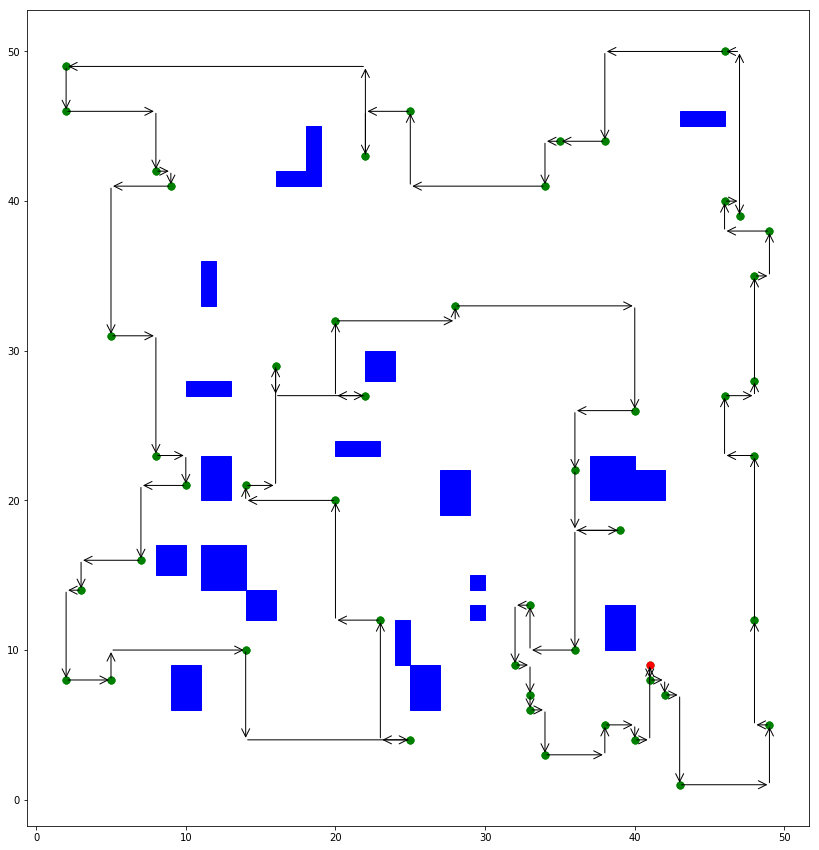

In [21]:
plt.figure(figsize=(15,15))
axes = plt.axes()

# Drawing blocks    
for block in blocks:
    x, y, w, h = block
    rect = plt.Rectangle((x, y), w, h, fc='blue', ec='blue')
    plt.gca().add_patch(rect)

# Drawing points
for data in result:
    src_x, src_y = data['src_coord']

    plt.scatter(src_x, src_y, s = 50, c = 'green' if src != 0 else 'red')

# Draw arrows
for data in result:
    src, dst = data['src'], data['dst']
    src_x, src_y = data['src_coord']
    dst_x, dst_y = data['dst_coord']
    path = data['path']
    
    plt.scatter(src_x, src_y, s = 50, c = 'green' if src != 0 else 'red')

    dx = dst_x - src_x
    dy = dst_y - src_y

    arrow1, arrow2 = None, None
        
    if path == 1:
        arrow1 = FancyArrowPatch ((src_x, src_y),(src_x + dx, src_y), arrowstyle='->', mutation_scale=20)
        arrow2 = FancyArrowPatch ((src_x + dx, src_y),(src_x + dx, src_y + dy), arrowstyle='->', mutation_scale=20)

    elif path == 2:
        arrow1 = FancyArrowPatch ((src_x, src_y),(src_x, src_y + dy), arrowstyle='->', mutation_scale=20)
        arrow2 = FancyArrowPatch ((src_x, src_y + dy),(src_x + dx, src_y + dy), arrowstyle='->', mutation_scale=20)

    axes.add_patch(arrow1)
    axes.add_patch(arrow2)
    
# Showing params    
plt.axis('scaled')
plt.show()

0 -> 13 -> 1 -> 22 -> 2 -> 32 -> 3 -> 37 -> 4 -> 46 -> 5 -> 9 -> 6 -> 42 -> 7 -> 8 -> 8 -> 1 -> 9 -> 43 -> 10 -> 11 -> 11 -> 18 -> 12 -> 39 -> 13 -> 34 -> 14 -> 28 -> 15 -> 40 -> 16 -> 24 -> 17 -> 0 -> 18 -> 3 -> 19 -> 49 -> 20 -> 30 -> 21 -> 10 -> 22 -> 16 -> 23 -> 12 -> 24 -> 35 -> 25 -> 17 -> 26 -> 48 -> 27 -> 4 -> 28 -> 5 -> 29 -> 41 -> 30 -> 14 -> 31 -> 44 -> 32 -> 38 -> 33 -> 31 -> 34 -> 21 -> 35 -> 23 -> 36 -> 15 -> 37 -> 7 -> 38 -> 33 -> 39 -> 20 -> 40 -> 6 -> 41 -> 47 -> 42 -> 29 -> 43 -> 2 -> 44 -> 45 -> 45 -> 26 -> 46 -> 19 -> 47 -> 27 -> 48 -> 36 -> 49 -> 25 -> 0